# Introduction to Remote Sensing, Remote Sensing Time Series Analysis, and Remote Sensing Indices

---

**Objectives:**

By the end of this exercise, you should be able to:
* explain what optical data is and give an example of how it is used
* explain the difference between remote sensing raster data and other raster data
* describe and calculate the Normalized Difference Water Index (NDWI)
* describe and plot the changes in NDWI over time

---

This exercise builds on our raster processes we covered in the raster data and API exercises. In this exercise, we are focusing on a subset of raster data from satellites, known as **remotely sensed** or **optical** data.

## Optical Data

**Remotely sensed** data is data used to describe an area where that data has been collected by measuring the reflected and emitted radiation over the area, often by a satellite. *Active* remote sensing is where a sensor emits radiation over an area and then measures the reflected radiation. Sonar systems on ships and submarines are a good example of an *active sensor*. *Passive* remote sensing is where a sensor measures radiation that is naturally emitted or reflected. In this case, the radiation is originating from the sun, then being reflected and/or emitted from the area and detected by the sensor. Satellites tend to have *passive sensors* that detect the reflected/emitted solar radiation from the Earth - this is **optical remote sensing**.

**Optical** remote sensing measures solar radiation reflected/emitted from an area. Different materials or land cover types absorb and reflect different wavelengths from the electromagnetic spectrum. We can use our knowledge of these spectral reflectance signatures to distinguish differnet land cover types or materials. (This is a very similar idea to electrospectrometry in chemistry.)

<img src="imgs/em_spectrum.png" width="650">

Source [IntechOpen.](https://www.intechopen.com/media/chapter/57384/media/F1.png)

<img src="imgs/spectral_reflect.jpg" width="650">

Source [SEOS Project.](https://seos-project.eu/remotesensing/images/Reflexionskurven.jpg)

<img src="imgs/remote_sensing.png" width="650">

Source [CRISP.](https://crisp.nus.edu.sg/~research/tutorial/optical.htm#:~:text=Optical%20remote%20sensing%20makes%20use,absorb%20differently%20at%20different%20wavelengths.)

## Exploring Planet imagery - PlanetScope

<img src="imgs/image.png" width="650">

The PlanetScope satellite constellation consists of multiple launches of groups of individual “small-satellites” (~200+ in total). Planet's on-orbit capacity is constantly improving in capability or quantity, with technology improvements deployed at a rapid pace. Each PlanetScope satellite is a CubeSat 3U form factor (10 cm by 10 cm by 30 cm). The complete PlanetScope is able to image the entire Earth every day (equating to a daily collection capacity of ~200 million km²/day).

In this in-class and homework data activity we will create a time series of surface water area for Lake Raleigh, a lake on Centennial Campus. 

We will be working on with surface reflectance [PlanetScope OrthoTiles](https://developers.planet.com/docs/data/psorthotile/).

The PlanetScope (PS) images have 4 bands: Blue, Green, Red, and Near Infrared. Each of these bands covers a range of wavelengths in the electromagnetic spectrum, and the first three bands are within the *visible spectrum*.

<img src="imgs/PS_S2_bands.png" width="650">

Source [here.](https://www.spiedigitallibrary.org/ContentImages/Journals/JARSC4/14/3/036504/WebImages/JARS_14_3_036504_f002.png)

We will use these bands to view Lake Raleigh over several dates, and we will use these bands to calculate an index that we can use to determine if a pixel is water or not.

## Plotting PlanetScope orthotiles

In this exercise, we will be using a new package, `earthpy` to help us with our raster visualizations.

From EathPy repo website:

*"Python is a generic programming language designed to support many different applications. Because of this, many commonly performed spatial tasks for science including plotting and working with spatial data take many steps of code. EarthPy builds upon the functionality developed for raster data (rasterio) and vector data (geopandas) in Python"*.

#### EarthPy (more info here: https://pypi.org/project/earthpy/)


In [20]:
# import modules
import os
from glob import glob #here is a very useful package to list files in a folder
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
from rasterio.plot import show
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt
import earthpy.plot as ep
import earthpy.spatial as es
import numpy as np

In [4]:
# list all PlanetScope imgs
PS_imgs = glob(os.path.join("data", "images", "PSScene", '*SR_harmonized_clip*.tif')) # note that we are using 2 wildcards here

PS_imgs.sort()
PS_imgs

['data\\images\\PSScene\\20211002_151913_02_1067_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211013_153632_1014_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211014_155732_17_2274_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211015_151210_35_2430_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211016_153550_1040_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211017_150734_75_2451_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211018_150816_27_241e_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211020_155656_19_241c_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211023_155723_24_2416_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211026_150844_91_2453_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211028_150916_0e26_3B_AnalyticMS_SR_harmonized_clip.tif',
 'data\\images\\PSScene\\20211031_153520_

EPSG:2264


<AxesSubplot:>

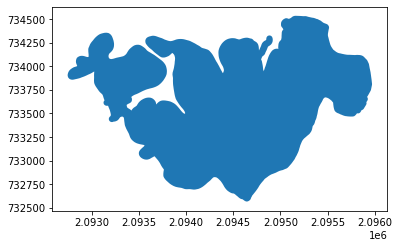

In [15]:
# get our Lake Raleigh shapefile (source: https://data.wakegov.com/datasets/water-bodies/)
lake_raleigh_path = "./data/Lake_Raleigh_10m_Buffer/Lake_Raleigh_10m_Buffer.shp"
# read in the shapefile
lake_raleigh_shp = gpd.read_file(lake_raleigh_path)
# set the CRS
lake_raleigh_shp = lake_raleigh_shp.set_crs('EPSG:2264')
# plot
lake_raleigh_shp.plot()

EPSG:32617


<AxesSubplot:title={'center':'nir band'}>

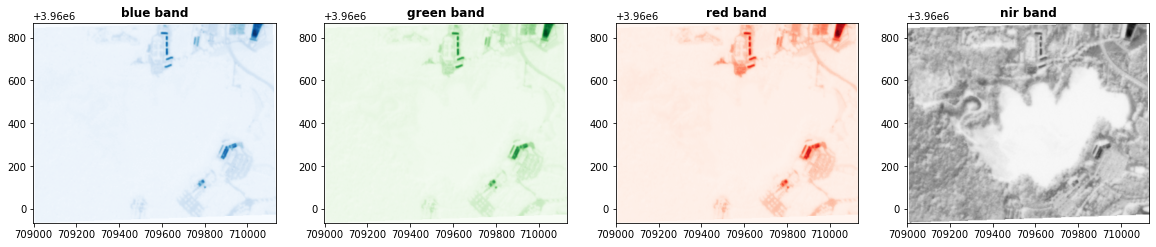

In [16]:
# get PS image path
src = rio.open(PS_imgs[0])

# get CRS
print(src.crs)

# create fig and subplots!
fig, (axb, axg, axr, axn) = plt.subplots(1,4, figsize=(20,5))
show((src, 1), ax=axb, cmap='Blues', title='blue band')
show((src, 2), ax=axg, cmap='Greens', title='green band')
show((src, 3), ax=axr, cmap='Reds', title='red band')
show((src, 4), ax=axn, cmap='Greys', title='nir band')

<AxesSubplot:>

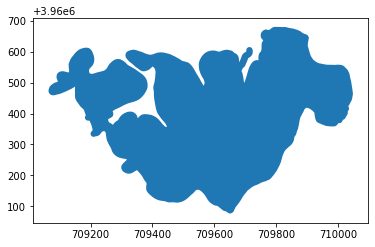

In [17]:
# reproject shapefile to raster CRS
lake_raleigh_shp = lake_raleigh_shp.to_crs(src.crs)

lake_raleigh_shp.plot()

In [166]:
PS_img_rxr = rxr.open_rasterio(PS_imgs[0],
                                 masked=False)

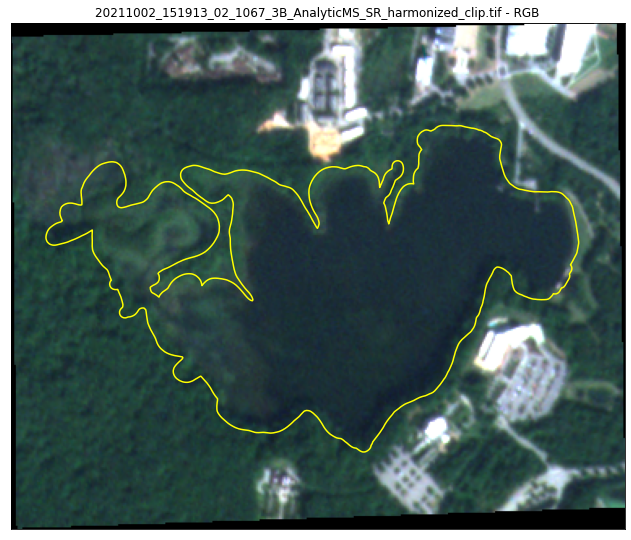

In [162]:
img_plot_extent = plotting_extent(PS_img_rxr[0], PS_img_rxr.rio.transform())

# Use earthpy to plot the Natural or True Color Composite (Red, Green, Blue)
f, ax = plt.subplots(figsize=(11, 12))

ep.plot_rgb(PS_img_rxr.values,
            rgb=(2, 1, 0),
            stretch=True, 
            title = f"{os.path.basename(PS_imgs[0])} - RGB", 
            extent= img_plot_extent,
            ax=ax)

lake_raleigh_shp.boundary.plot(ax=ax, color='yellow')

plt.show()

After reading in our data, we want to clip it to our shapefile. In this case, the shapefile of Lake Raleigh with a 10 meter buffer from shore.

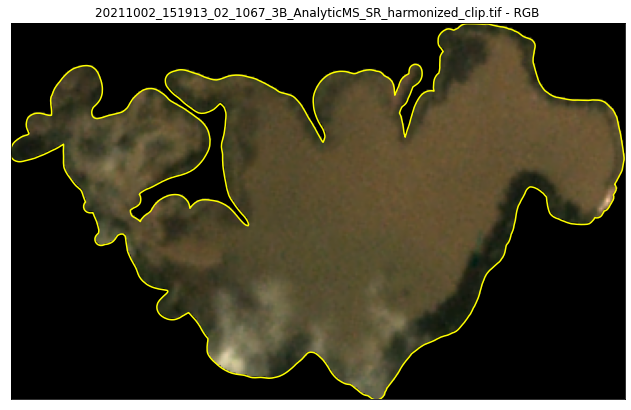

In [167]:
# clip the raster
PS_clipped = PS_img_rxr.rio.clip(lake_raleigh_shp.geometry)
# set the plotting extent
clip_plot_extent = plotting_extent(PS_clipped[0], PS_clipped.rio.transform())

# Use earthpy to plot the Natural or True Color Composite (Red, Green, Blue)
f, ax = plt.subplots(figsize=(11, 12))

ep.plot_rgb(PS_clipped.values,
            rgb=(2, 1, 0),
            stretch=False, 
            title = f"{os.path.basename(PS_imgs[0])} - RGB", 
            extent= clip_plot_extent,
            ax=ax)

lake_raleigh_shp.boundary.plot(ax=ax, color='yellow')

plt.show()

A False Color Composite - made up of the Near-IR, Red, and Green bands - can make certain land cover features more distinct. In the NRG False Color composite, we can see vegetation is red, water is dark blue, and urban areas are bright/white.

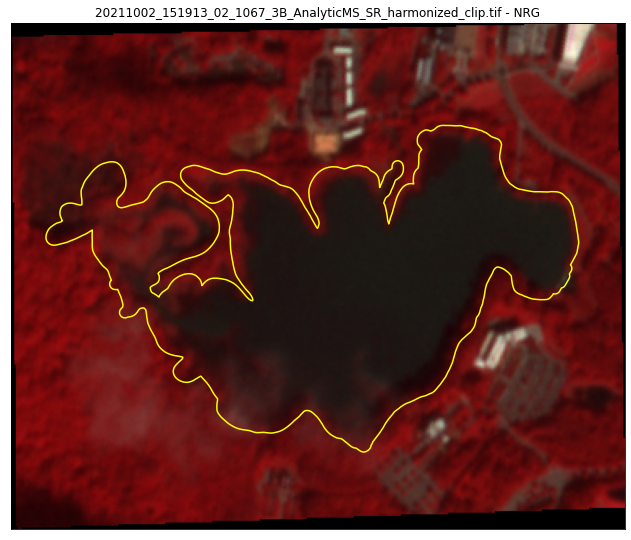

In [168]:
# Use earthpy to plot the False Color Composite (Near-IR, Red, Green)
f, ax = plt.subplots(figsize=(11, 12))

ep.plot_rgb(PS_img_rxr.values,
            rgb=(3, 2, 1),
            stretch=False, 
            title = f"{os.path.basename(PS_imgs[0])} - NRG", 
            extent= img_plot_extent,
            ax=ax)

lake_raleigh_shp.boundary.plot(ax=ax, color='yellow')

plt.show()


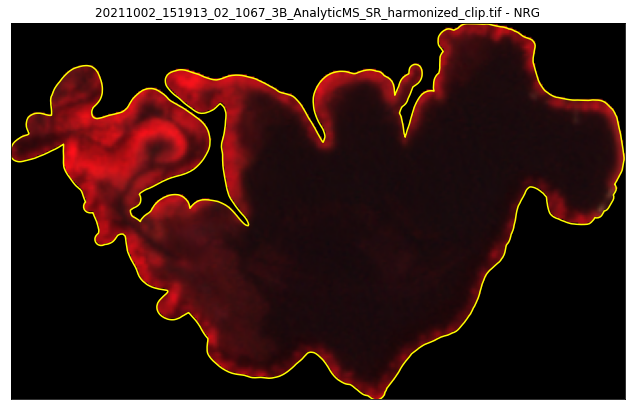

In [145]:
# Use earthpy to plot the False Color Composite (Near-IR, Red, Green)
f, ax = plt.subplots(figsize=(11, 12))

ep.plot_rgb(PS_clipped.values,
            rgb=(3, 2, 1),
            stretch=False, 
            title = f"{os.path.basename(PS_imgs[0])} - NRG", 
            extent= clip_plot_extent,
            ax=ax)

lake_raleigh_shp.boundary.plot(ax=ax, color='yellow')

plt.show()

## Calculate the Normalized Difference Water Index

We can determine water classification using a band-ratio (Normalized Difference Water Index) and a threshold.

The Normalized Difference Water Index (NDWI) is defined as follows:

**NDWI = (GREEN - NIR)/ (GREEN + NIR)**

Values closer to 1 represent water pixels, and values closer -1 represent non-water pixels. We will use a threshold of `-0.5` to classify pixels as water or non-water, where pixels with an NDWI value greater than -0.5 are classified as water and pixels with NDWI values less than -0.5 are classifies as non-water.

In [169]:
PS_g = PS_clipped[2-1].values.astype(np.int16) # the green band is Band 2 at index 1

PS_nir = PS_clipped[4-1].values.astype(np.int16) # the nir band is Band 4 at index 3

# the es package has a function for calculating indexes
# Function Description:
# (function) normalized_diff: (b1: Any, b2: Any) -> Any
# Take two n-dimensional numpy arrays and calculate the normalized difference.
# Math will be calculated (b1-b2) / (b1 + b2).
PS_ndwi_rxr = es.normalized_diff(PS_g, PS_nir) # == (PS_g - PS_nir) / (PS_g + PS_nir)

c:\Users\mdgaines\.conda\envs\NR491\lib\site-packages\earthpy\spatial.py:105: RuntimeWarning: invalid value encountered in divide
  n_diff = (b1 - b2) / (b1 + b2)


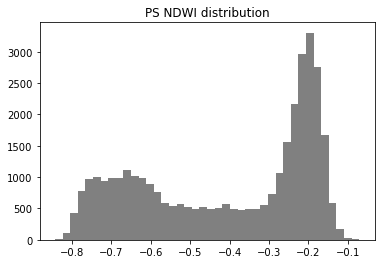

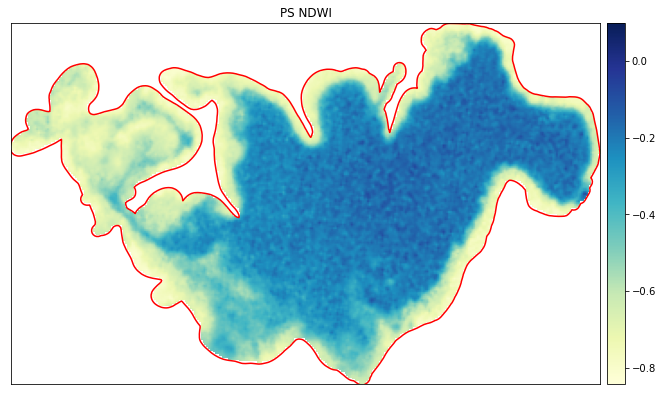

In [170]:
# let's plot using EarthPy functions
ep.hist(PS_ndwi_rxr,colors=["grey"],figsize=(6, 4), title="PS NDWI distribution", bins = 40)

f, ax = plt.subplots(figsize=(11, 12))
ep.plot_bands(PS_ndwi_rxr, 
              cmap='YlGnBu',
              scale=False,
              vmin=np.nanmin(PS_ndwi_rxr), vmax=0.1, # I set vnax after checking the histogram;
              title="PS NDWI",figsize=(5, 5),
              extent= clip_plot_extent,
            ax=ax)

lake_raleigh_shp.boundary.plot(ax=ax, color='red')

plt.show()

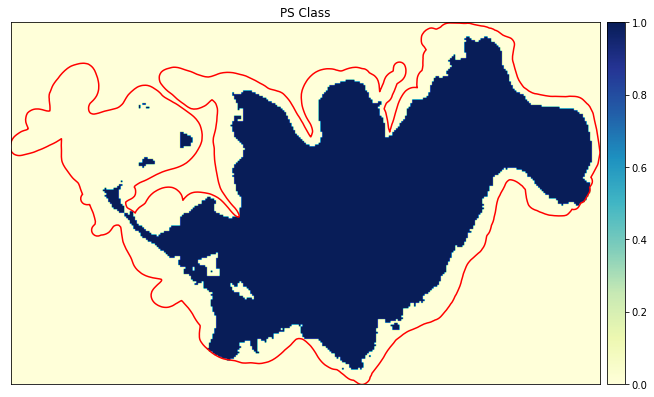

In [171]:
# Let's classify our water pixels using a threshold of -0.5
PS_class = np.where(PS_ndwi_rxr > -0.5, 1, 0)

f, ax = plt.subplots(figsize=(11, 12))
ep.plot_bands(PS_class, 
              cmap='YlGnBu',
              scale=False,
              title="PS Class",figsize=(5, 5),
              extent= clip_plot_extent,
              ax=ax)

lake_raleigh_shp.boundary.plot(ax=ax, color='red')

plt.show()


In [172]:
# to get the total number of water pixels, we can use the np.sum() function
np.sum(PS_class)

22203

## Time Series

Now, we need to repeat our steps above for all of the PS images and record the total number of water pixels at each date.

In [173]:
# ignore our divide by 0 warning
np.seterr(divide='ignore', invalid='ignore')

water_pixel_lst = []
for path in PS_imgs:
    # read in image
    PS_img_rxr = rxr.open_rasterio(path, masked=False)
    
    # clip the raster
    PS_clipped = PS_img_rxr.rio.clip(lake_raleigh_shp.geometry)
    
    # calculate NDWI
    PS_g = PS_clipped[2-1].values.astype(np.int16) # the green band is Band 2 at index 1
    PS_nir = PS_clipped[4-1].values.astype(np.int16) # the nir band is Band 4 at index 3
    PS_ndwi_rxr = es.normalized_diff(PS_g, PS_nir) # == (PS_g - PS_nir) / (PS_g + PS_nir)    

    # classify water
    PS_class = np.where(PS_ndwi_rxr > -0.5, 1, 0)

    # calculate total water pixels
    water_pixel_lst.append(np.sum(PS_class))

    # clear variables to reduce memory use
    del(PS_img_rxr, PS_clipped, PS_g, PS_nir, PS_ndwi_rxr, PS_class)

In [174]:
water_pixel_lst

[17853,
 22203,
 24127,
 23789,
 22720,
 23349,
 22125,
 20921,
 20653,
 26883,
 26081,
 22236,
 23469,
 23451,
 18979,
 23276,
 15293,
 22793]

In [180]:
# Get dates for PS images
PS_img_dates = ['-'.join([os.path.basename(i)[0:4],
                          os.path.basename(i)[4:6],
                          os.path.basename(i)[6:8]]) for i in PS_imgs]
PS_img_dates

['2021-10-02',
 '2021-10-13',
 '2021-10-14',
 '2021-10-15',
 '2021-10-16',
 '2021-10-17',
 '2021-10-18',
 '2021-10-20',
 '2021-10-23',
 '2021-10-26',
 '2021-10-28',
 '2021-10-31',
 '2021-11-01',
 '2021-11-08',
 '2021-11-09',
 '2021-11-10',
 '2021-11-13',
 '2021-11-14']

In [218]:
import pandas as pd
df = pd.DataFrame(zip(PS_img_dates, water_pixel_lst))
df

,0,1
0,2021-10-02,17853
1,2021-10-13,22203
2,2021-10-14,24127
3,2021-10-15,23789
4,2021-10-16,22720
5,2021-10-17,23349
6,2021-10-18,22125
7,2021-10-20,20921
8,2021-10-23,20653
9,2021-10-26,26883


In [203]:
import datetime
nan_date_lst = []
nan_lst = []
for date in df[0]:
    date1 = datetime.datetime.strptime(date, '%Y-%m-%d') + datetime.timedelta(days=1)
    date1 = datetime.datetime.strftime(date1, '%Y-%m-%d')
    while date1 not in list(df[0]):
        nan_date_lst.append(date1)
        nan_lst.append(np.nan)
        date1 = datetime.datetime.strptime(date1, '%Y-%m-%d') + datetime.timedelta(days=1)
        date1 = datetime.datetime.strftime(date1, '%Y-%m-%d')
    if date1 == '2021-11-14':
        break


In [219]:
df2 = pd.DataFrame(zip(nan_date_lst, nan_lst))
df2

,0,1
0,2021-10-03,NaN
1,2021-10-04,NaN
2,2021-10-05,NaN
3,2021-10-06,NaN
4,2021-10-07,NaN
5,2021-10-08,NaN
6,2021-10-09,NaN
7,2021-10-10,NaN
8,2021-10-11,NaN
9,2021-10-12,NaN


In [220]:
df = pd.concat([df, df2])
df = df.sort_values(by=0)
df

,0,1
0,2021-10-02,17853.0
0,2021-10-03,NaN
1,2021-10-04,NaN
2,2021-10-05,NaN
3,2021-10-06,NaN
4,2021-10-07,NaN
5,2021-10-08,NaN
6,2021-10-09,NaN
7,2021-10-10,NaN
8,2021-10-11,NaN


Text(0.5, 0, 'Date')

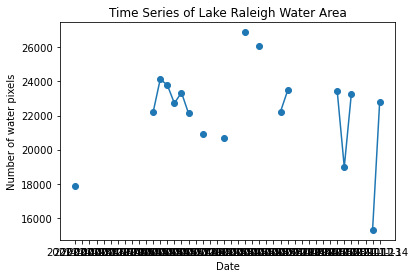

In [225]:
plt.plot(df[0], df[1], marker='o')
plt.title("Time Series of Lake Raleigh Water Area")
plt.ylabel("Number of water pixels")
plt.xlabel("Date")
# plt.set_xticklabels()